# 特徴量増やす
- era 毎の平均、標準偏差、max, min, count
- rag 特徴量（↑のNこ前、移動平均）

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics
from src.featuring import add_feature

# Config

In [3]:
class cfg:
    exp = "exp015"
    dataset_path = "../dataset/v5.0"
    feature_set = "medium"
    valid_ratio = 0.2
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [4]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set][:80]
print(f"feature col length: {len(feature_set)}")


targets = feature_metadata["targets"]
targets = ["target", "target_agnes_20"]


feature col length: 80


# Load Data

In [5]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 83)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,1,2,3,2,3,2,2,2,3,...,0,2,2,3,2,2,3,2,0.25,0.25
n003bba8a98662e4,0001,3,2,4,1,0,2,3,2,4,...,3,2,2,4,1,2,3,2,0.25,0.25


(3577827, 83)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,2,1,2,4,0,4,0,0,2,...,0,0,0,0,4,0,2,3,0.75,0.75
n001e1318d5072ac,0575,0,2,2,3,2,3,0,0,4,...,4,3,3,4,3,3,4,1,0.00,0.00


# Preprocess

In [6]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())

del train, valid; gc.collect()

(2746270, 83) (3577827, 83)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
nffce425c89dc5da,1153,0,4,2,4,2,2,1,4,1,...,0,2,2,4,4,2,0,1,NaN,NaN
nffd4e7b55827375,1153,1,4,0,1,0,0,4,4,4,...,4,0,4,0,4,4,0,4,NaN,NaN
nffea643830509bf,1153,2,3,4,2,2,1,4,2,4,...,4,1,2,0,4,1,4,4,NaN,NaN
nffea66c53d0aebe,1153,4,0,0,2,2,2,1,0,2,...,2,2,1,3,2,2,1,2,NaN,NaN
nfff2966f1f157af,1153,2,0,0,3,4,4,3,1,4,...,4,0,3,0,4,0,0,4,NaN,NaN


0

In [7]:
print(data.shape)

data = add_feature(data)

print(data.shape)

(6324097, 83)


  0%|          | 0/80 [00:00<?, ?it/s]

(6324097, 404)


../src/featuring.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["per_era_count"] = df.groupby("era")[features[0]].transform("count")


In [8]:
# era 単位で分ける
all_era = data["era"].unique()
n_idx = int(len(all_era) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train_era = all_era[:n_idx]
cond_train = data["era"].isin(train_era)
train, valid = data.loc[cond_train], data.loc[~cond_train]

print(train.shape, valid.shape)

del data; gc.collect()


(6324097, 404)
922
(4817566, 404) (1506531, 404)


0

In [9]:
train["era_int"] = train["era"].astype(int)

/tmp/ipykernel_21773/1731592198.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train["era_int"] = train["era"].astype(int)


# Training

In [10]:
features = feature_set + [col for col in train.columns if "per_era" in col]
print(len(features))

401


In [11]:
models = []

for target in targets:
    print("=" * 64)
    print("target: ", target)
    for i in range(4):
        cond_train = (train["era_int"] % 4 == i) & (~train[target].isnull())
        cond_valid = ~valid[target].isnull()
        tmp_train = train.loc[cond_train]
        tmp_valid = valid.loc[cond_valid]
        
        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(tmp_valid[features], tmp_valid[target]),
            early_stopping_rounds=10
        )
        models.append(model)
        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

target:  target


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 1202054, number of used features: 287
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 287
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 975
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 207
[LightGBM] [Warning] Provided parameters co

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 1201836, number of used features: 287
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 1202054, number of used features: 287
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 287
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 975
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 207
[LightGBM] [Warning] Provided parameters co

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 1201836, number of used features: 287
[LightGBM] [Warning] Provided parameters c

8


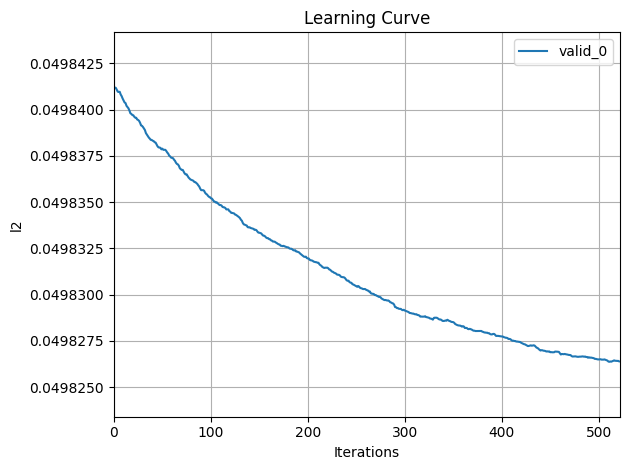

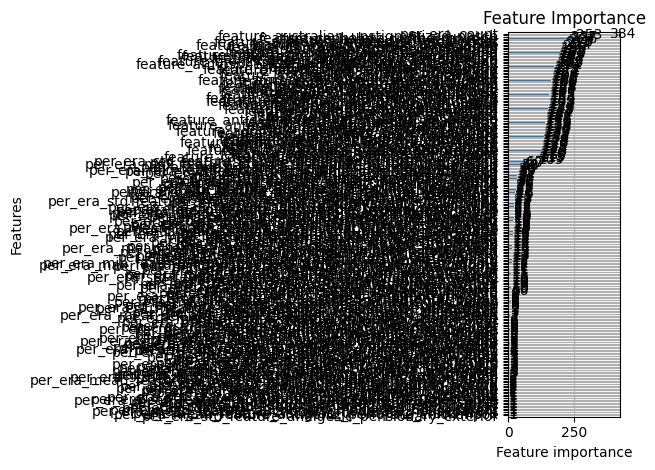

In [12]:
print(len(models))

for model in models:
    model.visualize_learning_curve()
    model.visualize_feature_importance()
    break

# Validation

/tmp/ipykernel_21773/695934008.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid["pred"] = preds


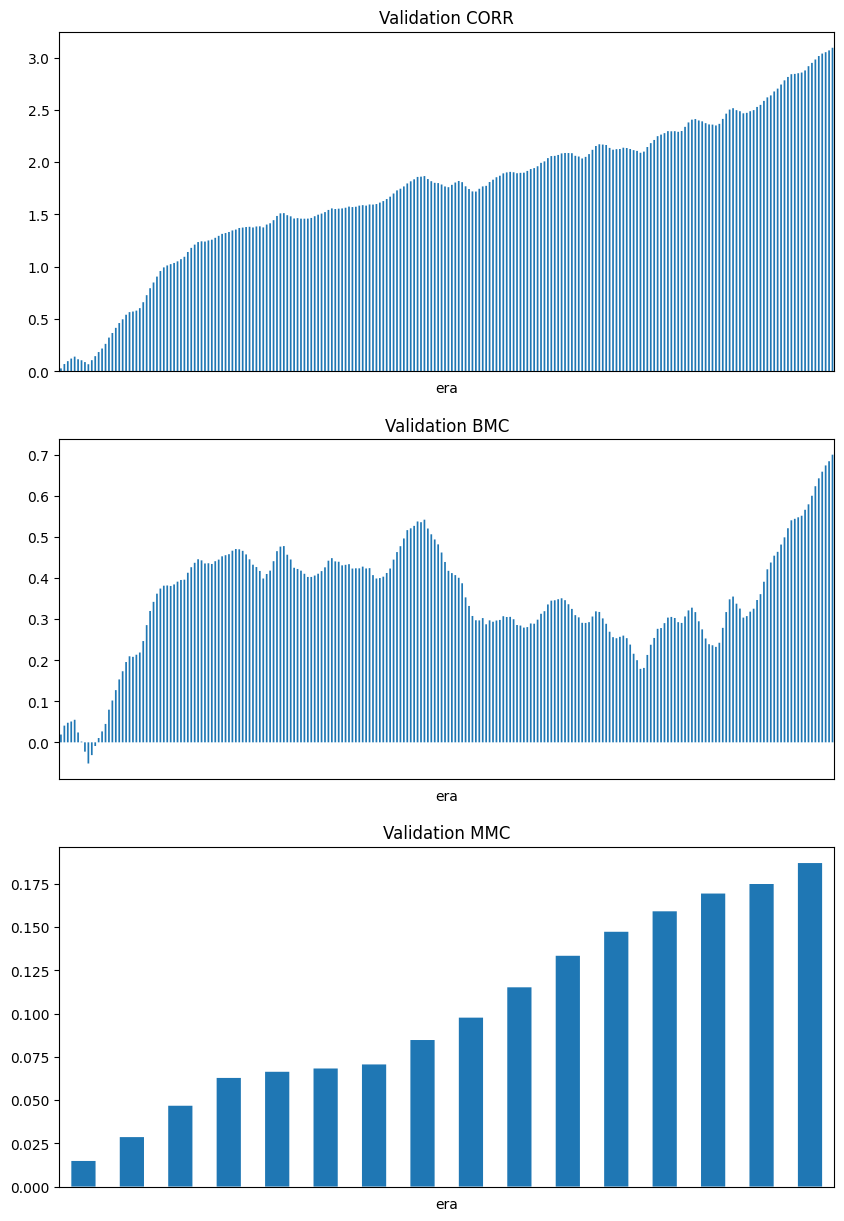

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean   mmc_std  \
 0   0.013688  0.019942    0.686426           0.147986  0.011685  0.005498   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0    2.12541               0.0  0.003102  0.014507   0.213857   
 
    bmc_max_drawdown  
 0          0.363572  ,
           pred
 era           
 0923  0.027546
 0924  0.041869
 0925  0.027535
 0926  0.024669
 0927  0.018481
 ...        ...
 1144  0.033235
 1145  0.023390
 1146  0.013279
 1147  0.017211
 1148  0.025102
 
 [226 rows x 1 columns],
           pred
 era           
 0923  0.018984
 0924  0.021742
 0925  0.006979
 0926  0.003058
 0927  0.004184
 ...        ...
 1144  0.019220
 1145  0.016190
 1146  0.015236
 1147  0.010254
 1148  0.015976
 
 [226 rows x 1 columns],
           pred
 era           
 1133  0.014808
 1134  0.013783
 1135  0.018119
 1136  0.016075
 1137  0.003550
 1138  0.001901
 1139  0.002344
 1140  0.014114
 1141  0.012928
 1142  0.017526

In [13]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds
caluculate_metrics(cfg.dataset_path, valid)
